## Level 2: Unit sales of all products, aggregated for all stores/states

In [1]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from tsforest.trend import compute_trend_models
from tsforest.forecaster import LightGBMForecaster

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage
from evaluation import WRMSSEEvaluator

SEEDS = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71]

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



***

In [2]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .groupby(["state_id","ds"])
        .agg({"q":"sum",
              "event_name_1":lambda x: int(x.unique()),
             })
        .reset_index()
       )

data["q"] = data.q.astype(int)
data.rename({"q":"y"}, axis=1, inplace=True)
data.sort_values(["state_id","ds"], inplace=True)
data.reset_index(drop=True, inplace=True)

In [3]:
weights_level2 = pd.read_parquet("../input/weights_level2.parquet")
weights_level2.head()

,state_id,weight
0,1,0.442371
1,2,0.269297
2,3,0.288332


In [4]:
scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales = compute_scaling(scaling_input, agg_columns=["state_id"]).rename({"q":"s"}, axis=1)
scales.head()

INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,state_id,s
0,1,2709.476919
1,2,1827.443035
2,3,1940.451981


In [5]:
weights = (weights_level2
    .merge(scales, how="inner", on=["state_id"])
    .assign(weight = lambda x: x.weight/x.s)
    .assign(weight = lambda x: x.weight/x.weight.median())
    .drop(["s"], axis=1)
)
weights.head()

,state_id,weight
0,1,1.098782
1,2,0.991738
2,3,1.000000


In [6]:
data = pd.merge(data, weights, how="left", on=["state_id"])
data.head()

,state_id,ds,y,event_name_1,weight
0,1,2011-01-29,14195,1,1.098782
1,1,2011-01-30,13805,1,1.098782
2,1,2011-01-31,10108,1,1.098782
3,1,2011-02-01,11047,1,1.098782
4,1,2011-02-02,9925,1,1.098782


***
### time series visualization

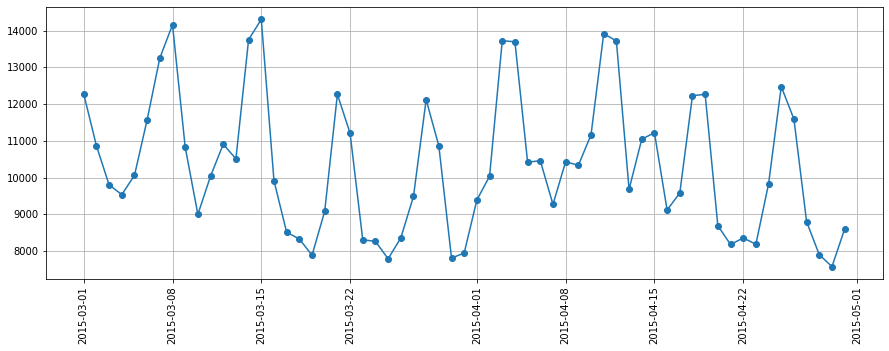

In [7]:
state_id = 3
start_date = '2015-03-01'
end_date = '2015-04-30'

df = data.query("state_id == @state_id & @start_date <= ds <= @end_date")

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.y, "o-")
plt.xticks(rotation=90)
plt.grid()
plt.show()

***

In [8]:
valid_periods = [(pd.to_datetime("2015-04-25"), pd.to_datetime("2015-05-22")),
                 (pd.to_datetime("2015-05-23"), pd.to_datetime("2015-06-19")),
                 (pd.to_datetime("2016-02-27"), pd.to_datetime("2016-03-26")),
                 (pd.to_datetime("2016-03-27"), pd.to_datetime("2016-04-24")),
                ]
valid_periods

[(Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')),
 (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')),
 (Timestamp('2016-02-27 00:00:00'), Timestamp('2016-03-26 00:00:00')),
 (Timestamp('2016-03-27 00:00:00'), Timestamp('2016-04-24 00:00:00'))]

***
### training validation models

In [9]:
model_params = {
    'objective':'l2',
    'metric':'None',
    'num_iterations':10000,
    'early_stopping_rounds':250,
    #'max_bin': 255,
    'num_leaves': 31, 
    'learning_rate': 0.1, 
    'min_data_in_leaf': 20,
    #'min_sum_hessian_in_leaf':1e-4,
    'feature_fraction': 0.66,
    'bagging_fraction':0.9,
    'bagging_freq':1,
    'lambda_l2':1.,
    'seed':23
}

time_features = [
    "year",
    "month",
    "year_week",
    "year_day",
    "week_day",
    "month_progress",
    "week_day_cos",
    "week_day_sin",
    "year_day_cos",
    "year_day_sin",
    "year_week_cos",
    "year_week_sin",
    "month_cos",
    "month_sin"
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "categorical_features":{
        "state_id":"default",
        "event_name_1":"default"},
    "ts_uid_columns":["state_id"],
    
}

In [10]:
# 4+ years of history
train_history = 1800

In [11]:
models = list()
errors = list()
best_iterations = list()

for i,valid_period in enumerate(valid_periods):
    print(f" {i+1}/{len(valid_periods)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)
        
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);

    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)
    
    evaluator = WRMSSEEvaluator(_fcaster.valid_features.loc[:, ["ds"]+_fcaster.ts_uid_columns+["y"]], 
                                weights_level2, 
                                scales,
                                ts_uid_columns=_fcaster.ts_uid_columns)
    _fcaster.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})

    
    models.append(_fcaster)
    errors.append(_fcaster.model.model.best_score["valid_0"]["wrmsse"])
    best_iterations.append(_fcaster.best_iteration)

############################################### 1/4 ################################################
##### Validation period: (Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')) ######
####################################################################################################
Training until validation scores don't improve for 250 rounds
[25]	valid_0's wrmsse: 0.436421
[50]	valid_0's wrmsse: 0.328758
[75]	valid_0's wrmsse: 0.304055
[100]	valid_0's wrmsse: 0.295541
[125]	valid_0's wrmsse: 0.296087
[150]	valid_0's wrmsse: 0.290544
[175]	valid_0's wrmsse: 0.289808
[200]	valid_0's wrmsse: 0.290767
[225]	valid_0's wrmsse: 0.290154
[250]	valid_0's wrmsse: 0.289291
[275]	valid_0's wrmsse: 0.290448
[300]	valid_0's wrmsse: 0.289213
[325]	valid_0's wrmsse: 0.288294
[350]	valid_0's wrmsse: 0.284523
[375]	valid_0's wrmsse: 0.286064
[400]	valid_0's wrmsse: 0.284285
[425]	valid_0's wrmsse: 0.283524
[450]	valid_0's wrmsse: 0.281815
[475]	valid_0's wrmsse: 0.28304
[500]	valid_

***
### training final model

In [12]:
model_kwargs["model_params"]["num_iterations"] = int(np.median(best_iterations))
model_kwargs["model_params"]

{'objective': 'l2',
 'metric': 'None',
 'num_iterations': 492,
 'early_stopping_rounds': 250,
 'num_leaves': 31,
 'learning_rate': 0.1,
 'min_data_in_leaf': 20,
 'feature_fraction': 0.66,
 'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'lambda_l2': 1.0,
 'seed': 23}

In [13]:
train_data = data.copy(deep=True)
all_models = list()

for seed in SEEDS:
    model_kwargs["model_params"]["seed"] = seed
    fcaster = LightGBMForecaster(**model_kwargs)
    fcaster.prepare_features(train_data=train_data);
    fcaster.fit()
    all_models.append(fcaster)

***
### estimating residuals

In [15]:
train_data.loc[:, ["ds","state_id","event_name_1","weight"]]

,ds,state_id,event_name_1,weight
0,2011-01-29,1,1,1.098782
1,2011-01-30,1,1,1.098782
2,2011-01-31,1,1,1.098782
3,2011-02-01,1,1,1.098782
4,2011-02-02,1,1,1.098782
...,...,...,...,...
5734,2016-04-20,3,1,1.000000
5735,2016-04-21,3,1,1.000000
5736,2016-04-22,3,1,1.000000
5737,2016-04-23,3,1,1.000000


In [17]:
residual_variance = list()

for fcaster in all_models:
    predictions = fcaster.predict(train_data.loc[:, ["ds","state_id","event_name_1","weight"]])
    #rv = (pd.merge(train_data, predictions, how="inner", on="ds")
    #      .assign(residual = lambda x: x.y - x.y_pred)
    #      .residual.std())
    #residual_variance.append(rv)
    break

In [22]:
(pd.merge(train_data, predictions, how="inner", on=["ds","state_id"])
 .assign(residual = lambda x : x.y - x.y_pred)
 .groupby("state_id")["residual"].std()
 .reset_index()
)

,state_id,residual
0,1,400.530432
1,2,380.307743
2,3,409.911164


***
### prediction

In [19]:
valid_dataframe = (pd.read_parquet("../input/valid_dataframe.parquet")
                   .loc[:, ["ds","state_id","event_name_1"]]
                   .drop_duplicates()
                   .merge(weights, how="left", on="state_id"))
eval_dataframe = (pd.read_parquet("../input/eval_dataframe.parquet")
                  .loc[:, ["ds","state_id","event_name_1"]]
                  .drop_duplicates()
                  .merge(weights, how="left", on="state_id"))

In [20]:
all_forecasts = list()
for fcaster in all_models:
    _forecast = fcaster.predict(pd.concat([valid_dataframe, eval_dataframe], ignore_index=True))
    all_forecasts.append(_forecast)
    
forecast = all_forecasts[0].copy(deep=True)
forecast["y_pred"] = np.mean([_forecast.y_pred for _forecast in all_forecasts], axis=0)

In [21]:
forecast.to_csv("../output/forecast_level2.csv", index=False)

***